[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/crunchdao/quickstarters/blob/master/competitions/structural-break/quickstarters/baseline/baseline.ipynb)

![Banner](https://raw.githubusercontent.com/crunchdao/quickstarters/refs/heads/master/competitions/structural-break/assets/banner.webp)

# ADIA Lab Structural Break Challenge

## Challenge Overview

Welcome to the ADIA Lab Structural Break Challenge! In this challenge, you will analyze univariate time series data to determine whether a structural break has occurred at a specified boundary point.

### What is a Structural Break?

A structural break occurs when the process governing the data generation changes at a certain point in time. These changes can be subtle or dramatic, and detecting them accurately is crucial across various domains such as climatology, industrial monitoring, finance, and healthcare.

![Structural Break Example](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/structural-break/quickstarters/baseline/images/example.png)

### Your Task

For each time series in the test set, you need to predict a score between `0` and `1`:
- Values closer to `0` indicate no structural break at the specified boundary point;
- Values closer to `1` indicate a structural break did occur.

### Evaluation Metric

The evaluation metric is [ROC AUC (Area Under the Receiver Operating Characteristic Curve)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), which measures the performance of detection algorithms regardless of their specific calibration.

- ROC AUC around `0.5`: No better than random chance;
- ROC AUC approaching `1.0`: Perfect detection.

# Setup

The first steps to get started are:
1. Get the setup command
2. Execute it in the cell below

### >> https://hub.crunchdao.com/competitions/structural-break/submit/notebook

![Reveal token](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/animations/reveal-token.gif)

In [14]:
# Install the Crunch CLI
%pip install --upgrade crunch-cli

# Setup your local environment
# !crunch setup --notebook structural-break hello --token aaaabbbbccccddddeeeeffff

# %pip install crunch-cli --upgrade
# !crunch setup-notebook structural-break OXwM5fn77qKfwxwMgsz8L6of

%pip install crunch-cli --upgrade
!crunch setup-notebook structural-break Z86o0Rn7BWmdDKfMB1kFuceO

you appear to have never submitted code before
data/X_train.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/y_train.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
                                
---
Success! Your environment has been correctly setup.
Next recommended actions:
1. Load the Crunch Toolings: `crunch = crunch.load_notebook()`
2. Execute the cells with your code
3. Run a test: `crunch.test()`
4. Download and submit your code to the platform!


# Your model

## Setup

In [10]:
import os
import typing

# Import your dependencies
import joblib
import pandas as pd
import scipy
import sklearn.metrics

In [15]:
import crunch

# Load the Crunch Toolings
crunch = crunch.load_notebook()

loaded inline runner with module: <module '__main__'>

cli version: 6.4.4
available ram: 12.67 gb
available cpu: 2 core
----


## Understanding the Data

The dataset consists of univariate time series, each containing ~2,000-5,000 values with a designated boundary point. For each time series, you need to determine whether a structural break occurred at this boundary point.

The data was downloaded when you setup your local environment and is now available in the `data/` directory.

In [16]:
import os

def list_files_in_directory(dir_path):
  """Lists all files in the specified directory.

  Args:
    dir_path: The path to the directory. If not specified, the current
      working directory is used.

  Returns:
    A list of strings, where each string is the name of a file in the directory.
    Returns an empty list if the directory does not exist or is empty.
  """

  try:
    files = os.listdir(dir_path)
    return files
  except FileNotFoundError:
    print(f"Error: Directory '{dir_path}' not found.")
    return []

# Example usage:
# os.chdir('./sample_data')
current_dir_files = list_files_in_directory(os.getcwd())
print("Files in current directory:", current_dir_files)

print(os.getcwd())

# print(os.getcwd())

# current_dir_files = list_files_in_directory(os.getcwd())
# print("Files in current directory:", current_dir_files)

Files in current directory: ['anscombe.json', 'README.md', 'resources', '.crunchdao', 'data', 'california_housing_train.csv', 'california_housing_test.csv', 'mnist_test.csv', 'mnist_train_small.csv']
/content/sample_data


In [17]:
# Load the data simply
X_train, y_train, X_test = crunch.load_data()

data/X_train.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_train.parquet: already exists, file length match
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/X_test.reduced.parquet: already exists, file length match
data/y_train.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_train.parquet: already exists, file length match
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
data/y_test.reduced.parquet: already exists, file length match


### Understanding `X_train`

The training data is structured as a pandas DataFrame with a MultiIndex:

**Index Levels:**
- `id`: Identifies the unique time series
- `time`: The timestep within each time series

**Columns:**
- `value`: The actual time series value at each timestep
- `period`: A binary indicator where `0` represents the **period before** the boundary point, and `1` represents the **period after** the boundary point

In [18]:
X_train

value  period
id    time                  
0     0    -0.005564       0
      1     0.003705       0
      2     0.013164       0
      3     0.007151       0
      4    -0.009979       0
...              ...     ...
10000 2134  0.001137       1
      2135  0.003526       1
      2136  0.000687       1
      2137  0.001640       1
      2138  0.001074       1

[23715734 rows x 2 columns]

### Understanding `y_train`

This is a simple `pandas.Series` that tells if a dataset id has a structural breakpoint or not.

**Index:**
- `id`: the ID of the dataset

**Value:**
- `structural_breakpoint`: Boolean indicating whether a structural break occurred (`True`) or not (`False`)

In [19]:
y_train

,structural_breakpoint
id,
0,False
1,False
2,True
3,False
4,False
...,...
9996,False
9997,False
9998,False


In [20]:
print('X_train')
print(X_train.info())
print(X_train)

print('y_train')
print(y_train.info())
print(y_train)

print(y_train.value_counts(normalize=True))

X_train
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 23715734 entries, (np.int64(0), np.int64(0)) to (np.int64(10000), np.int64(2138))
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   value   float64
 1   period  int64  
dtypes: float64(1), int64(1)
memory usage: 452.8 MB
None
               value  period
id    time                  
0     0    -0.005564       0
      1     0.003705       0
      2     0.013164       0
      3     0.007151       0
      4    -0.009979       0
...              ...     ...
10000 2134  0.001137       1
      2135  0.003526       1
      2136  0.000687       1
      2137  0.001640       1
      2138  0.001074       1

[23715734 rows x 2 columns]
y_train
<class 'pandas.core.series.Series'>
Index: 10001 entries, 0 to 10000
Series name: structural_breakpoint
Non-Null Count  Dtype
--------------  -----
10001 non-null  bool 
dtypes: bool(1)
memory usage: 87.9 KB
None
id
0        False
1        False
2         True
3        Fal

<ipython-input-21-e0e54e014166>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['level'] = df[['value']].cumsum()


         count      mean       std       min       25%       50%       75%  \
period                                                                       
0       2333.0  0.000389  0.017221 -0.085878 -0.008929  0.000677  0.009887   
1        515.0  0.001790  0.022900 -0.083094 -0.009794  0.001324  0.014051   

             max  
period            
0       0.087720  
1       0.130874  
         value  period     level
time                            
2843  0.006456       1  1.826298
2844 -0.007016       1  1.819281
2845  0.030775       1  1.850056
2846 -0.001799       1  1.848257
2847 -0.018562       1  1.829695
y_train: True


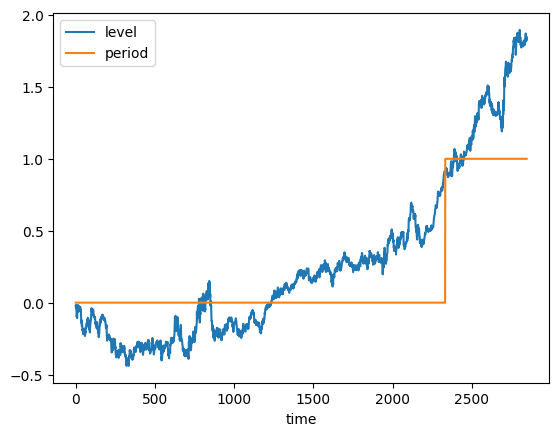

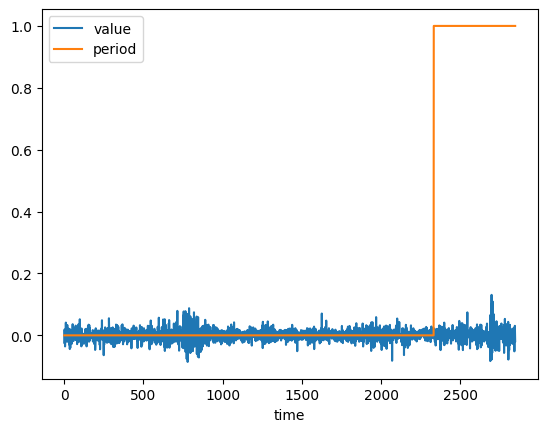

In [21]:
def extract_values_by_id(df, n):
    """
    Extract all rows for a given id number 'n' from a DataFrame
    with a MultiIndex of ['id', 'time'].

    Parameters:
        df (pd.DataFrame): The input DataFrame with a MultiIndex.
        n (int): The id value to filter on.

    Returns:
        pd.DataFrame: Filtered DataFrame with rows corresponding to id 'n'.
    """
    return df.loc[n]

import pandas as pd

# Example DataFrame setup
# data = {
#     'value': [-0.005564, 0.003705, 0.013164],
#     'period': [0, 0, 0]
# }
# index = pd.MultiIndex.from_tuples([(0, 0), (1, 0), (2, 0)], names=['id', 'time'])
# df = pd.DataFrame(data, index=index)

# Extract values for id = 1
id = 2
df = extract_values_by_id(X_train, id)
df['level'] = df[['value']].cumsum()

df[['level','period']].plot()

df[['value','period']].plot()

print(df.groupby('period').describe()['value'])
print(df.tail())
print(f"y_train: {y_train.loc[id]}")

In [22]:
y_train.value_counts()

,count
structural_breakpoint,
False,7092
True,2909


### Understanding `X_test`

The test data is provided as a **`list` of `pandas.DataFrame`s** with the same format as [`X_train`](#understanding-X_test).

It is structured as a list to encourage processing records one by one, which will be mandatory in the `infer()` function.

In [ ]:
print("Number of datasets:", len(X_test))

Number of datasets: 101


In [ ]:
X_test[0]

value  period
id    time                  
10001 0    -0.020657       0
      1    -0.005894       0
      2    -0.003052       0
      3    -0.000590       0
      4     0.009887       0
...              ...     ...
      2517  0.005084       1
      2518 -0.024414       1
      2519 -0.014986       1
      2520  0.012999       1
      2521 -0.022138       1

[2522 rows x 2 columns]

## Strategy Implementation

There are multiple approaches you can take to detect structural breaks:

1. **Statistical Tests**: Compare distributions before and after the boundary point;
2. **Feature Engineering**: Extract features from both segments for comparison;
3. **Time Series Modeling**: Detect deviations from expected patterns;
4. **Machine Learning**: Train models to recognize break patterns from labeled examples.

The baseline implementation below uses a simple statistical approach: a t-test to compare the distributions before and after the boundary point.

### The `train()` Function

In this function, you build and train your model for making inferences on the test data. Your model must be stored in the `model_directory_path`.

The baseline implementation below doesn't require a pre-trained model, as it uses a statistical test that will be computed at inference time.

In [23]:
def train(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    model_directory_path: str,
):
    # For our baseline t-test approach, we don't need to train a model
    # This is essentially an unsupervised approach calculated at inference time
    model = None

    # You could enhance this by training an actual model, for example:
    # 1. Extract features from before/after segments of each time series
    # 2. Train a classifier using these features and y_train labels
    # 3. Save the trained model

    joblib.dump(model, os.path.join(model_directory_path, 'model.joblib'))

### The `infer()` Function

In the inference function, your trained model (if any) is loaded and used to make predictions on test data.

**Important workflow:**
1. Load your model;
2. Use the `yield` statement to signal readiness to the runner;
3. Process each dataset one by one within the for loop;
4. For each dataset, use `yield prediction` to return your prediction.

**Note:** The datasets can only be iterated once!

In [24]:
def infer(
    X_test: typing.Iterable[pd.DataFrame],
    model_directory_path: str,
):
    model = joblib.load(os.path.join(model_directory_path, 'model.joblib'))

    yield  # Mark as ready

    # X_test can only be iterated once.
    # Before getting the next dataset, you must predict the current one.
    for dataset in X_test:
        # Baseline approach: Compute t-test between values before and after boundary point
        # The negative p-value is used as our score - smaller p-values (larger negative numbers)
        # indicate more evidence against the null hypothesis that distributions are the same,
        # suggesting a structural break
        def t_test(u: pd.DataFrame):
            return -scipy.stats.ttest_ind(
                u["value"][u["period"] == 0],  # Values before boundary point
                u["value"][u["period"] == 1],  # Values after boundary point
            ).pvalue

        prediction = t_test(dataset)
        yield prediction  # Send the prediction for the current dataset

        # Note: This baseline approach uses a t-test to compare the distributions
        # before and after the boundary point. A smaller p-value (larger negative number)
        # suggests stronger evidence that the distributions are different,
        # indicating a potential structural break.

## Local testing

To make sure your `train()` and `infer()` function are working properly, you can call the `crunch.test()` function that will reproduce the cloud environment locally. <br />
Even if it is not perfect, it should give you a quick idea if your model is working properly.

In [28]:
train(X_train, y_train, './resources')
infer(X_test, './resources')

<generator object infer at 0x7e25344219c0>

In [29]:
crunch.test(
    # Uncomment to disable the train
    force_first_train=False,

    # Uncomment to disable the determinism check
    no_determinism_check=True,
)

19:39:13 no forbidden library found
19:39:13 
19:39:13 started
19:39:13 running local test
19:39:13 internet access isn't restricted, no check will be done
19:39:13 
19:39:14 starting unstructured loop...
19:39:14 executing - command=infer


data/X_train.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_train.parquet: already exists, file length match
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/X_test.reduced.parquet: already exists, file length match
data/y_train.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_train.parquet: already exists, file length match
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
data/y_test.reduced.parquet: already exists, file length match


19:39:15 save prediction - path=data/prediction.parquet
19:39:15 ended
19:39:15 duration - time=00:00:01
19:39:15 memory - before="1.02 GB" after="1.02 GB" consumed="2.23 MB"


## Results

Once the local tester is done, you can preview the result stored in `data/prediction.parquet`.

In [30]:
prediction = pd.read_parquet("data/prediction.parquet")
prediction

,prediction
id,
10001,-0.590381
10002,-0.363831
10003,-0.731208
10004,-0.762609
10005,-0.527371
...,...
10097,-0.539917
10098,-0.843084
10099,-0.203762


### Local scoring

You can call the function that the system uses to estimate your score locally.

In [31]:
# Load the targets
target = pd.read_parquet("data/y_test.reduced.parquet")["structural_breakpoint"]

# Call the scoring function
sklearn.metrics.roc_auc_score(
    target,
    prediction,
)

np.float64(0.48450704225352115)

# Submit your Notebook

To submit your work, you must:
1. Download your Notebook from Colab
2. Upload it to the platform
3. Create a run to validate it

### >> https://hub.crunchdao.com/competitions/structural-break/submit/notebook

![Download and Submit Notebook](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/animations/download-and-submit-notebook.gif)